In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from time import time as tm

import torch 
from models import RateModel
from utils import ToNP, MakeSmoothGaussianProcess, TorchPCA


# Save figures?
SaveFigs=True


# Choose a device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device='cpu'
print('Device =',device)

torch.manual_seed(0)

# Number of neurons in recurrent net
N = 200

# Duration of simulation in ms
dt = 0.01


# Number of excitatory, inhibitory, and external neurons
Ne = int(N*.75)
Ni = N-Ne

# Connection weights
jee = .5/np.sqrt(N)
jei = -2/np.sqrt(N)
jie = 1.0/np.sqrt(N)
jii = -1.0/np.sqrt(N)



# Mean external input scaling
xe0 = 0.2*np.sqrt(N)
xi0 = 0.1*np.sqrt(N)

# Mean field
WMF=torch.tensor([[jee*Ne,jei*Ni],[jie*Ne,jii*Ni]])
XMF=torch.tensor([xe0,xi0], dtype=torch.double)
rMF=torch.linalg.inv(torch.eye(2)-WMF)@XMF
print('Mean field fixed pt:',rMF)
# Synaptic timescales
taue = 2
taui = 1
JacMF=torch.tensor([[(jee*Ne-1)/taue, jei*Ni/taue],[jie*Ne/taui, (jii*Ni-1)/taui]])
lamMF=np.linalg.eigvals(JacMF)
print('e-vals of MFJac',lamMF)


# # Array of synaptic timescales
tausyn = torch.zeros(N).to(device)
tausyn[:Ne] = taue
tausyn[Ne:] = taui
eta = dt/tausyn

# Spectral radius of random part
rho = 0.5

with torch.no_grad():

    # Get synaptic connectivity matrix
    t0=tm()
    W0 = torch.zeros(N,N).to(device)
    W0[:Ne,:Ne] = jee
    W0[:Ne,Ne:] = jei
    W0[Ne:,:Ne] = jie
    W0[Ne:,Ne:] = jii
    W1 = rho*torch.randn(N,N).to(device)/np.sqrt(N)
    W = W0 + W1
    print('Mean and std of EE entries:',W[:Ne,:Ne].mean(),W[:Ne,:Ne].std())
    tJ = tm()-t0
    print('Time to generate connectivity:',tJ,'s')
    


    # Build model
    model = RateModel(W, f='tanh', eta = eta, bias_recurrent=False, Network_Type='Z').to(device)


    t0=tm()
    #sigmaW = ToNP(torch.linalg.svdvals(W.cpu()))
    UW,sigmaW,VWT = torch.linalg.svd(W.cpu())
    UW0,sigmaW0,VW0T = torch.linalg.svd(W0.cpu())
    VW0=VW0T.T
    #sigmaW = ToNP(sigmaW)
    PW0 = (UW0.T@VW0T.T)[:2,:2]
    tsvdW = tm()-t0
    print('Time for svdW calc:',tsvdW,'s')


u = UW0[:,0]
v = VW0[:,0]
urand = torch.randn(N)
urand = urand/urand.norm()

####### Second simulation for PCA plot

# Duration of sim
T2=5000

# Timescale and strength of Guassian random stimulus
taux=20
sigmax=.5

# Discretized time for second sim
time2=np.arange(0,T2,dt)
Nt2=len(time2)


# Generate input and run sim
with torch.no_grad():
    t0=tm()
    x2 = sigmax*MakeSmoothGaussianProcess(taux,Nt2,dt,N,device=device).T
    x2 = x2[None,:,:].float().to(device)
    tx = tm()-t0
    print('Time to generate x(t):',tx,'s')
    t0=tm()
    r2 = model(x2, return_time_series = True, store_hidden_history = True, initial_state=.1*torch.randn(N).to(device) )
    z2 = model.hidden_state_history
    
    tsim2 = tm()-t0
    print('Time for second sim:',tsim2,'s')

    # Perform PCA on x and z
    t0=tm()
    Nburn=int(100/dt)
    Ux,Sx=TorchPCA(x2[0,Nburn:,:], scaled=False)
    Uz,Sz=TorchPCA(z2[0,Nburn:,:], scaled=False)
    print('Time for PCA calc:',tm()-t0)


    # Get input variable
    y2=model.recurrent_layer(r2)



    # Define projected variables
    xu = x2[0,:,:]@u
    xurand = x2[0,:,:]@urand
    zu = z2[0,:,:]@u
    zurand = z2[0,:,:]@urand
    yu = y2[0,:,:]@u
    ru = r2[0,:,:]@u

    # Define projected variables
    xv = x2[0,:,:]@v
    zv = z2[0,:,:]@v
    yv = y2[0,:,:]@v
    rv = r2[0,:,:]@v

    xycorr = torch.corrcoef(torch.stack((xu,yu)))[0,1].item()
    print('corr coef between xu and yu=Wru:',xycorr)


    uuangle=(180/np.pi)*torch.arccos(torch.nn.functional.cosine_similarity(Uz[:,-1],u.cpu(),dim=0)).item()
    print('Angle btwn smallest sing vec and u:',uuangle,'degrees')




Device = cpu
Mean field fixed pt: tensor([0.0510, 0.4310], dtype=torch.float64)
e-vals of MFJac [-1.19194174+5.13034028j -1.19194174-5.13034028j]
Mean and std of EE entries: tensor(0.0347) tensor(0.0355)
Time to generate connectivity: 0.0010747909545898438 s
Time for svdW calc: 0.00465703010559082 s
Time to generate x(t): 1.4762511253356934 s
Time for second sim: 12.30086612701416 s
Time for PCA calc: 2.9460697174072266
corr coef between xu and yu=Wru: -0.9266170859336853
Angle btwn smallest sing vec and u: 79.09301002266821 degrees


done


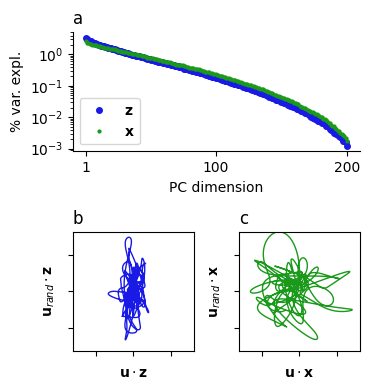

In [2]:


### Make Figure
xclr = [.1,.6,.1]
yclr = [.7,.2,.7]
zclr = [.1,.1,.9]
Wclr = [.8,.1,.1]

numplot = N


fig, axes = plt.subplot_mosaic("aa;bc",figsize=(3.8,4))

c0='a'
ax0 = axes[c0]
ax0.plot(np.arange(N)+1,100*Sz/Sz.sum(),'o',label=r'$\mathbf{z}$',markersize=4,color=zclr)
ax0.plot(np.arange(N)+1,100*Sx/Sx.sum(),'.',label=r'$\mathbf{x}$',markersize=4,color=xclr)
#ax0.plot(np.arange(N)+1,100*SCzlin/SCzlin.sum(),'.',label=r'$\mathbf{z}\;(W=W_1)$',markersize=2,color='r')
ax0.set_xscale('linear')
ax0.set_yscale('log')
ax0.set_xlabel('PC dimension')
ax0.set_xticks([1,int(N/2),N])
#ax0.set_yticks([10, 100])
ax0.set_ylabel('% var. expl.')
ax0.legend(loc='lower left')
ax0.set_title(c0,loc='left')
sns.despine(ax=ax0)



c0='b'
ax0 = axes[c0]
xumax=torch.max(torch.cat((torch.abs(xu),torch.abs(xurand)))).item()
zumax=torch.max(torch.cat((torch.abs(zu),torch.abs(zurand)))).item()
xzumax=max(xumax,zumax)

I2plot=int(2000/dt)
numplot=N
ax0.plot(ToNP(zu[:I2plot]),ToNP(zurand[:I2plot]),color=zclr,lw=1)
ax0.axis([-xzumax,xzumax,-xzumax,xzumax])
ax0.set_xticks([-1,0,1])
ax0.set_yticks([-1,0,1])
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{z}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{z}$')
ax0.set_title(c0,loc='left')

c0='c'
ax0 = axes[c0]
ax0.plot(ToNP(xu[:I2plot]),ToNP(xurand[:I2plot]),color=xclr,lw=1)
ax0.axis([-xzumax,xzumax,-xzumax,xzumax])
ax0.set_xticks([-1,0,1])
ax0.set_yticks([-1,0,1])
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xlabel(r'$\mathbf{u}\cdot\mathbf{x}$')
ax0.set_ylabel(r'$\mathbf{u}_{rand}\cdot\mathbf{x}$')
ax0.set_title(c0,loc='left')


fig.tight_layout()


if SaveFigs:
    fig.savefig('./Figures/SuppFigModular.pdf')
    fig.savefig('./Figures/SuppFigModularunpolished.svg')
print('done')

